In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
# setup all the imports
import matplotlib.font_manager
import matplotlib.pyplot as plt
import cartopy.crs as ccrs  # noqa: E402
import numpy as np
import seaborn as sns
import pandas as pd

flist = matplotlib.font_manager.get_font_names()
from pathlib import Path  # noqa: E402

from extremeweatherbench import cases, defaults, evaluate, regions  # noqa: E402

# make the basepath - change this to your local path
basepath = Path.home() / "extreme-weather-bench-paper" / ""
basepath = str(basepath) + "/"

# ugly hack to load in our plotting scripts
# import sys  # noqa: E402

#sys.path.append(basepath + "/docs/notebooks/")
import src.plots.paper_plotting as pp  # noqa: E402


In [41]:

# load in all of the events in the yaml file
print("loading in the events yaml file")
ewb_cases = cases.load_ewb_events_yaml_into_case_collection()
# build out all of the expected data to evalate the case
# this will not be a 1-1 mapping with ewb_cases because there are multiple data sources
# to evaluate for some cases
# for example, a heat/cold case will have both a case operator for ERA-5 data and GHCN
case_operators = cases.build_case_operators(
    ewb_cases, defaults.get_brightband_evaluation_objects()
)


loading in the events yaml file


In [42]:
# to plot the targets, we need to run the pipeline for each case and target
from joblib import Parallel, delayed  # noqa: E402
from joblib.externals.loky import get_reusable_executor  # noqa: E402

# load in all the case info (note this takes awhile in non-parallel form as it has to
# run all the target information for each case)
# this will return a list of tuples with the case id and the target dataset

print("running the pipeline for each case and target")
parallel = Parallel(n_jobs=32, return_as="generator", backend="loky")
case_operators_with_targets_established_generator = parallel(
    delayed(
        lambda co: (
            co.case_metadata.case_id_number,
            evaluate.run_pipeline(co.case_metadata, co.target),
        )
    )(case_operator)
    for case_operator in case_operators
)
case_operators_with_targets_established = list(
    case_operators_with_targets_established_generator
)
# this will throw a bunch of errors below but they're not consequential. this releases
# the memory as it shuts down the workers
get_reusable_executor().shutdown(wait=True)


running the pipeline for each case and target


/home/amy/extreme-weather-bench-paper/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


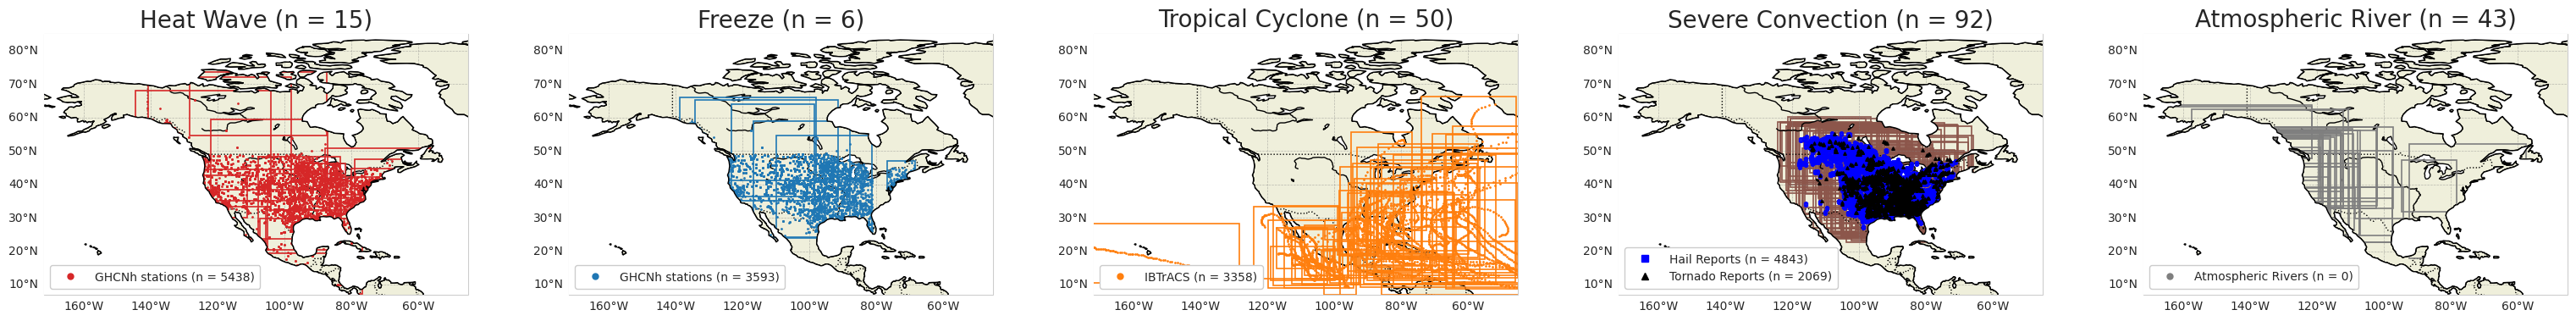

In [43]:
# plot all the cases in North America
# North America
na_bounding_box = [-172, -45, 7, 85]

fig, axs = plt.subplots(1, 5, figsize=(40, 4),subplot_kw={'projection': ccrs.PlateCarree()})
# setup the figure to have no space between the subplots
fig.subplots_adjust(wspace=0)

pp.plot_all_cases_and_obs(ewb_cases, event_type="heat_wave", targets=case_operators_with_targets_established, 
    bounding_box=na_bounding_box, ax=axs[0], show_legend=True)

pp.plot_all_cases_and_obs(ewb_cases, event_type="freeze", targets=case_operators_with_targets_established, 
    bounding_box=na_bounding_box, ax=axs[1], show_legend=True)

pp.plot_all_cases_and_obs(ewb_cases, event_type="tropical_cyclone", targets=case_operators_with_targets_established, 
    bounding_box=na_bounding_box, ax=axs[2], show_legend=True)

pp.plot_all_cases_and_obs(ewb_cases, event_type="severe_convection", targets=case_operators_with_targets_established, 
    bounding_box=na_bounding_box, ax=axs[3], show_legend=True)

pp.plot_all_cases_and_obs(ewb_cases, event_type="atmospheric_river", targets=case_operators_with_targets_established, 
    bounding_box=na_bounding_box, ax=axs[4], show_legend=True)

